## Problem Definition

The objective is to predict the (x, y) coordinates of a single bright pixel 
(value = 255) in a 50×50 grayscale image. All other pixels have a value of 0.

## Dataset Design Rationale

Since no real dataset is provided, I have generated a synthetic dataset.
So, each image contains exactly one pixel with intensity 255 placed at a 
random location, while all other pixels are zero.

This is done because random placement ensures uniform spatial coverage across the image, 
preventing positional bias. Synthetic data is suitable here because the 
problem is deterministic and ground truth labels are exact. This setup is done to force the model learn spatial localization rather than 
memorizing patterns.

## Dependencies for the Assessment

- Python 3.10
- TensorFlow 2.x
- NumPy
- Matplotlib
- Scikit-learn

Install using:
pip install tensorflow numpy matplotlib scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def generate_dataset(num_samples: int = 5000,
                     image_size: int = 50):
    """
    Generates a dataset of grayscale images with a single bright pixel.

    Args:
        num_samples (int): Number of samples to generate.
        image_size (int): Height and width of the square image.

    Returns:
        X (np.ndarray): Image data of shape (N, H, W, 1)
        y (np.ndarray): Coordinates of bright pixel (x, y)
    """
    X = np.zeros((num_samples, image_size, image_size, 1),
                 dtype=np.float32)
    y = np.zeros((num_samples, 2), dtype=np.float32)

    for i in range(num_samples):
        x = np.random.randint(0, image_size)
        y_coord = np.random.randint(0, image_size)

        X[i, y_coord, x, 0] = 255.0
        y[i] = [x, y_coord]

    X /= 255.0     # Normalize pixel values to [0, 1]

    return X, y

In [2]:
# Dataset Generation
X, y = generate_dataset(num_samples=5000)

print("Input shape:", X.shape)
print("Target shape:", y.shape)
print("Sample target (x, y):", y[0])

Input shape: (5000, 50, 50, 1)
Target shape: (5000, 2)
Sample target (x, y): [39. 16.]


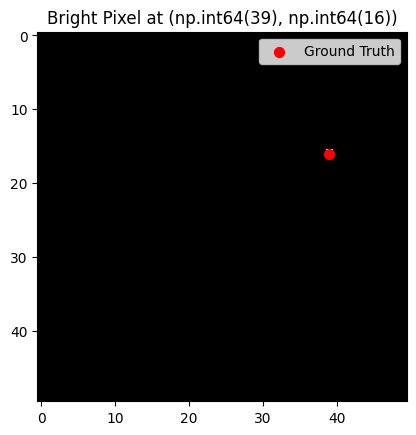

In [3]:
def visualize_sample(X, y, index: int = 0):
    plt.imshow(X[index].squeeze(), cmap="gray")
    plt.scatter(y[index][0], y[index][1],
                c="red", s=50, label="Ground Truth")
    plt.legend()
    plt.title(f"Bright Pixel at {tuple(y[index].astype(int))}")
    plt.show()


visualize_sample(X, y, index=0)

## Data Preprocessing

The input images are already normalized to the range [0, 1].
To improve numerical stability during training, target coordinates
(x, y) are also normalized by the image size.

In [4]:
from sklearn.model_selection import train_test_split

IMAGE_SIZE = 50

# Normalize coordinates to [0, 1]
y_normalized = y / IMAGE_SIZE

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y_normalized,
    test_size=0.2,
    random_state=42
)

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])

Training samples: 4000
Validation samples: 1000


In [5]:
# Sanity checks
assert X_train.shape[1:] == (50, 50, 1)
assert y_train.shape[1] == 2

print("X_train min/max:", X_train.min(), X_train.max())
print("y_train min/max:", y_train.min(), y_train.max())

X_train min/max: 0.0 1.0
y_train min/max: 0.0 0.98


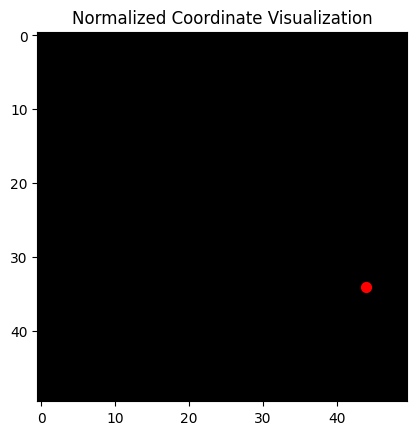

In [6]:
def visualize_normalized_sample(X, y, index=0):
    img = X[index].squeeze()
    x_norm, y_norm = y[index]

    x = int(x_norm * IMAGE_SIZE)
    y_coord = int(y_norm * IMAGE_SIZE)

    plt.imshow(img, cmap="gray")
    plt.scatter(x, y_coord, c="red", s=50)
    plt.title("Normalized Coordinate Visualization")
    plt.show()


visualize_normalized_sample(X_train, y_train, index=0)

## Model Architecture

A shallow Convolutional Neural Network (CNN) is used to preserve spatial
information while learning a mapping from pixel intensity to spatial location.

The network consists of a small number of convolutional layers followed by
fully connected layers that regress the (x, y) coordinates of the bright pixel.
I have used this design for intentionally minimal to avoid over-parameterization.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models


def build_model(input_shape=(50, 50, 1)):
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation="relu",
                      input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        layers.Dense(64, activation="relu"),
        layers.Dense(2, activation="linear")  # (x, y)
    ])

    return model


model = build_model()
model.summary()

c:\Users\Tushar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       247,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,802 (987.51 KB)

 Trainable params: 252,802 (987.51 KB)

 Non-trainable params: 0 (0.00 B)

## Training Objective

The model is trained using Mean Squared Error (MSE) loss since the task
requires regression of continuous (x, y) coordinates. MSE directly
penalizes the distance between predicted and ground truth pixel locations.

The Adam optimizer is used due to its adaptive learning rate and stable
convergence behavior, making it suitable for this regression task.

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse"
)

## Training Strategy

The model is trained for a limited number of epochs to demonstrate
learning behavior without overfitting. A moderate batch size is used
to ensure stable gradient updates. Validation loss is monitored to
verify generalization to unseen data.

In [9]:
EPOCHS = 25
BATCH_SIZE = 32

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0304 - val_loss: 0.0041
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 7.5754e-04 - val_loss: 6.4473e-04
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 4.9658e-04 - val_loss: 3.9821e-04
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4.2717e-04 - val_loss: 4.1772e-04
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 3.1558e-04 - val_loss: 2.7665e-04
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.8143e-04 - val_loss: 2.7890e-04
Epoch 9/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 2.5209e-04 - val_loss: 3.1108e-04
Epoch 10/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 2.1466e-04 - val_loss: 1.9075e-04
Epoch 11/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.8326e-04 

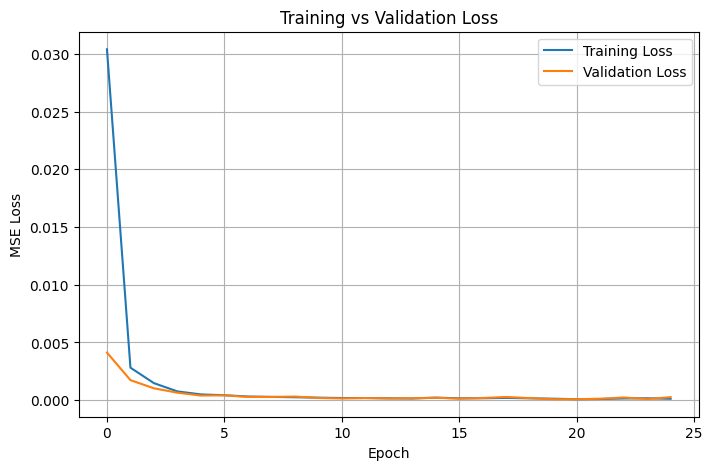

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Predict on validation set
y_val_pred = model.predict(X_val)

print("Predictions shape:", y_val_pred.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Predictions shape: (1000, 2)


In [12]:
# Denormalize predictions and ground truth
y_val_pred_px = y_val_pred * IMAGE_SIZE
y_val_true_px = y_val * IMAGE_SIZE

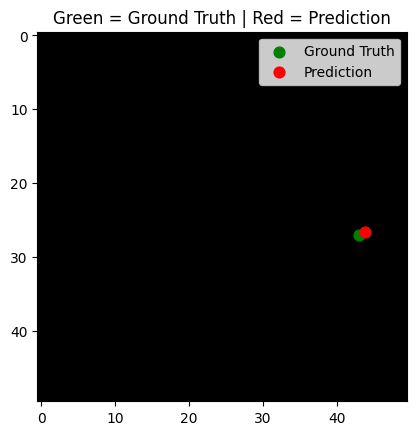

In [13]:
def visualize_prediction(X, y_true, y_pred, index=0):
    img = X[index].squeeze()

    x_true, y_true_coord = y_true[index]
    x_pred, y_pred_coord = y_pred[index]

    plt.imshow(img, cmap="gray")
    plt.scatter(x_true, y_true_coord,
                c="green", s=60, label="Ground Truth")
    plt.scatter(x_pred, y_pred_coord,
                c="red", s=60, label="Prediction")

    plt.legend()
    plt.title("Green = Ground Truth | Red = Prediction")
    plt.show()


visualize_prediction(X_val, y_val_true_px, y_val_pred_px, index=5)

In [14]:
# Compute Euclidean distance error
pixel_errors = np.linalg.norm(
    y_val_true_px - y_val_pred_px,
    axis=1
)

print("Mean pixel error:", np.mean(pixel_errors))
print("Median pixel error:", np.median(pixel_errors))

Mean pixel error: 0.9942083
Median pixel error: 0.93310857


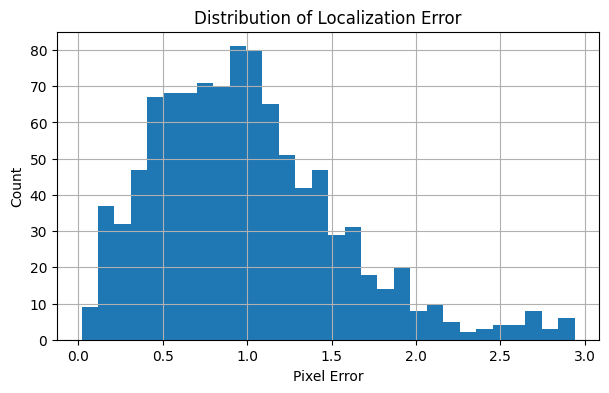

In [15]:
plt.figure(figsize=(7, 4))
plt.hist(pixel_errors, bins=30)
plt.xlabel("Pixel Error")
plt.ylabel("Count")
plt.title("Distribution of Localization Error")
plt.grid(True)
plt.show()

## Error Analysis & Limitations

Most localization errors are within one pixel. Larger errors occasionally
occur due to spatial resolution reduction from pooling layers. This is an
expected tradeoff between precision and robustness. The task is deliberately simple. therefore, i kept the model capacity minimal.

## Conclusion

Through this project i have demonstrated a complete deep learning pipeline for spatial
localization. with the help of synthetic dataset to ensure uniform coverage,
and a shallow CNN was trained to regress pixel coordinates.